In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

import sys
sys.path.insert(0, '/home/561/jn8053/~/.local/lib')
from xarrayMannKendall import *

clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/41975/status,
Dashboard: /proxy/41975/status,Workers: 4
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34299,Workers: 4
Dashboard: /proxy/41975/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:35929,Total threads: 4
Dashboard: /proxy/35559/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:41475,


In [2]:
keys = ['erai', 'era5', 'cfsr', 'jra55', 'cmip6', 'reanalysis']

In [3]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask.nc')['__xarray_dataarray_variable__']
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu'].sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90, -50.1, .1))), 1, np.nan).interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, land_ice_mask['lon'] + 360, land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon': '_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj': sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj': 'lon'})

# Divide line calculated as:
# cset = plt.contour(mask['lon'][1:], mask['lat'], xr.where(np.isnan(mask[:,1:]), 1, 0), levels = [0]); plt.close()
# div_lin = np.array([cset.allsegs[0][1][:,0], cset.allsegs[0][1][:,1]])
div_line = xr.open_dataset('../data/smooth_div_line.nc')['__xarray_dataarray_variable__']

In [4]:
uas = {}
vas = {}
psl = {}
for k in keys:
    uas[k] = xr.open_dataset('../data/uas-monthly-1979_2015-'+k+'.nc')['uas']
    vas[k] = xr.open_dataset('../data/vas-monthly-1979_2015-'+k+'.nc')['vas']
    psl[k] = xr.open_dataset('../data/psl-monthly-1979_2015-'+k+'.nc')['psl']

In [5]:
uas_proj = xr.open_dataset('../data/uas-monthly-2015_2100-cmip6ssp85.nc')['uas']
vas_proj = xr.open_dataset('../data/vas-monthly-2015_2100-cmip6ssp85.nc')['vas']
psl_proj = xr.open_dataset('../data/psl-monthly-2015_2100-cmip6ssp85.nc')['psl']

## Trends historical period

In [10]:
uas_trends = {}; vas_trends = {}
for k in keys:
    u = uas[k].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    uas_trends[k] = MK_class.compute()
    uas_trends[k] = uas_trends[k].rename({'x':'lon', 'y':'lat'})
    
    v = vas[k].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(v, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    vas_trends[k] = MK_class.compute()
    vas_trends[k] = vas_trends[k].rename({'x':'lon', 'y':'lat'})
    
    print(k)

erai
era5
cfsr
jra55
cmip6
reanalysis


## Trends 21st century

In [8]:
u = uas_proj.groupby('time.year').mean('time')
MK_class = Mann_Kendall_test(u, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
uas_trends_proj = MK_class.compute()
uas_trends_proj = uas_trends_proj.rename({'x':'lon', 'y':'lat'})

v = vas_proj.groupby('time.year').mean('time')
MK_class = Mann_Kendall_test(v, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
vas_trends_proj = MK_class.compute()
vas_trends_proj = vas_trends_proj.rename({'x':'lon', 'y':'lat'})

## SLP difference

In [17]:
psl_historical = psl['cmip6'].sel(time = slice('2005-01-01', '2015-01-01')).mean('time') - \
                 psl['cmip6'].sel(time = slice('1979-01-01', '1989-01-01')).mean('time')

In [24]:
psl_projection = psl_proj.sel(time = slice('2090-01-01', '2100-01-01')).mean('time') - \
                 psl_proj.sel(time = slice('2015-01-01', '2025-01-01')).mean('time')

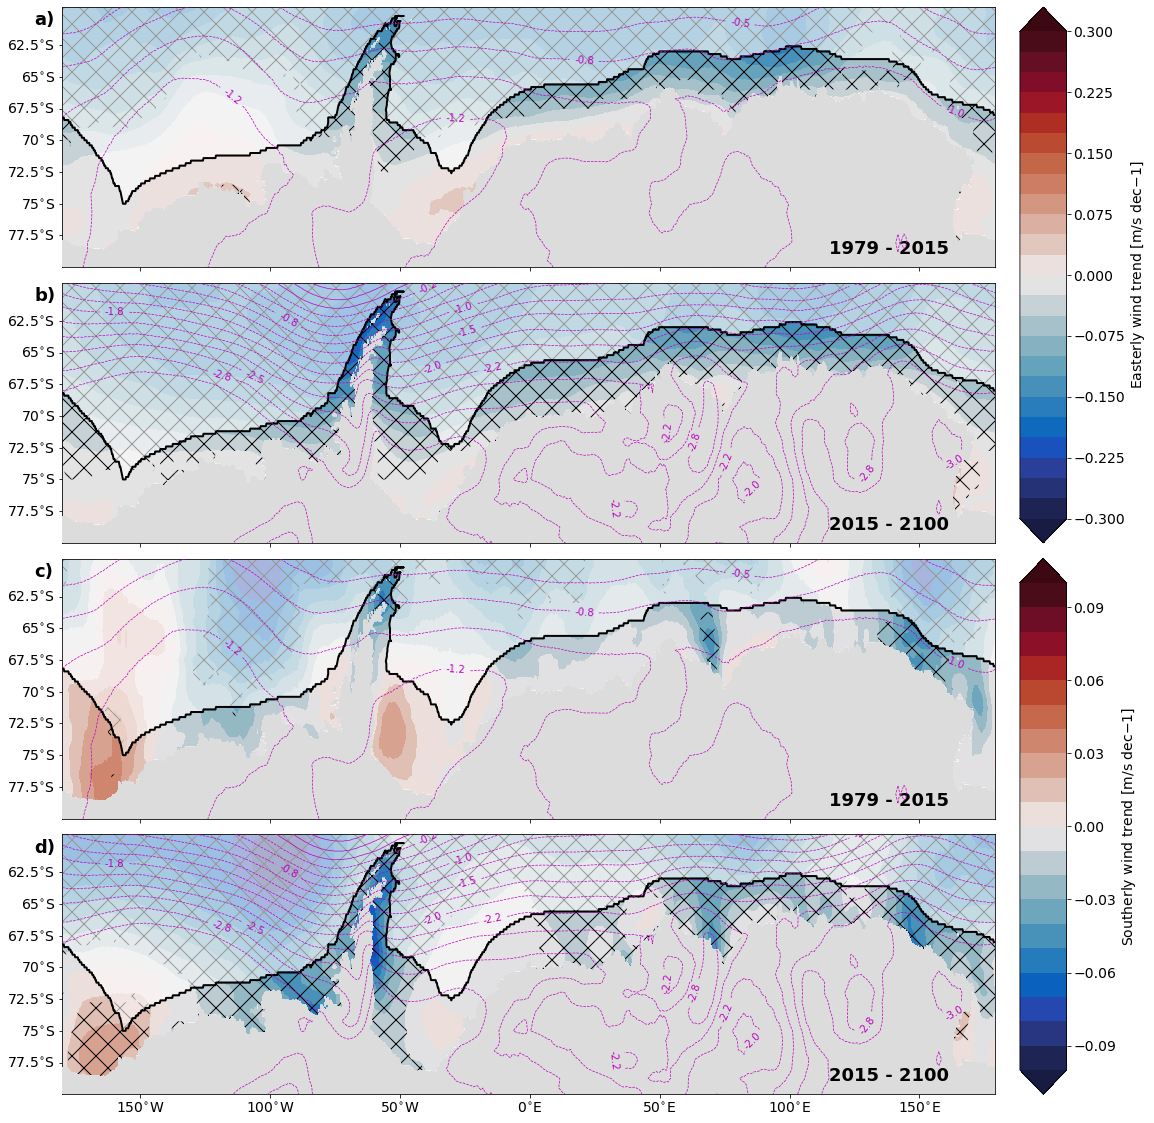

In [35]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 20))
gr = gs.GridSpec(4, 2, figure = fig, width_ratios = [1,.05], hspace = .06, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[2,0]),
       fig.add_subplot(gr[3,0]), 
       fig.add_subplot(gr[:2,1]), 
       fig.add_subplot(gr[2:,1])]
for ax, label in zip(axs[:-1], ['a)', 'b)', 'c)', 'd)']):
    ax.text(-0.03, .93, label, transform = ax.transAxes, size = 18, weight = 'bold')
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-77.5, -60, 2.5))
    ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', '70$^{\circ}$S', 
                        '67.5$^{\circ}$S', '65$^{\circ}$S', '62.5$^{\circ}$S'])
    if ax in [axs[0], axs[1], axs[2]]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', 
                            '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'gainsboro', 
                linewidths = 0.5, zorder = 3)
    ax.pcolormesh(mask['lon'], mask['lat'], xr.where(np.isnan(mask), 1, np.nan), vmin = 1, 
                  vmax = 1.1, cmap = 'binary', alpha = 0.6, zorder = 2)
    ax.plot(div_line[0], div_line[1], 'k', linewidth = 2, zorder = 2)
    if ax in [axs[0], axs[2]]:
        ax.text(0.95, .05, '1979 - 2015', ha = 'right', transform = ax.transAxes, size = 18, weight = 'bold')
    else:
        ax.text(0.95, .05, '2015 - 2100', ha = 'right', transform = ax.transAxes, size = 18, weight = 'bold')
    
c = axs[0].contourf(uas_trends['cmip6']['lon'], uas_trends['cmip6']['lat'], -uas_trends['cmip6']['trend']*10, 
                    levels = np.arange(-.3, .325, .025), extend = 'both', cmap = cmocean.cm.balance)
fig.colorbar(c, cax = axs[-2], orientation = 'vertical').set_label('Easterly wind trend [m/s dec${-1}$]')
axs[0].contourf(uas_trends['cmip6']['lon'], uas_trends['cmip6']['lat'], uas_trends['cmip6']['p'].where(uas_trends['cmip6']['p'] <= .05),
                colors = ['none'], hatches = ['x'])
c = axs[0].contour(psl_historical['lon'], psl_historical['lat'], psl_historical/100,
                   levels = np.arange(-3, 3.25, .25), colors = ['m'], linewidths = [0.7], zorder = 4)
axs[0].clabel(c, c.levels, inline=True, fmt='%1.1f', fontsize=10)

axs[1].contourf(uas_trends_proj['lon'], uas_trends_proj['lat'], -uas_trends_proj['trend']*10, levels = np.arange(-.3, .325, .025), 
                extend = 'both', cmap = cmocean.cm.balance)
axs[1].contourf(uas_trends_proj['lon'], uas_trends_proj['lat'], uas_trends_proj['p'].where(uas_trends_proj['p'] <= .05),
                colors = ['none'], hatches = ['x'])
c = axs[1].contour(psl_projection['lon'], psl_projection['lat'], psl_projection/100,
                   levels = np.arange(-3, 3.25, .25), colors = ['m'], linewidths = [0.7], zorder = 4)
axs[1].clabel(c, c.levels, inline=True, fmt='%1.1f', fontsize=10)

c = axs[2].contourf(vas_trends['cmip6']['lon'], vas_trends['cmip6']['lat'], vas_trends['cmip6']['trend']*10, 
                    levels = np.arange(-.1, .11, .01), extend = 'both', cmap = cmocean.cm.balance)
fig.colorbar(c, cax = axs[-1], orientation = 'vertical').set_label('Southerly wind trend [m/s dec${-1}$]')
axs[2].contourf(vas_trends['cmip6']['lon'], vas_trends['cmip6']['lat'], vas_trends['cmip6']['p'].where(vas_trends['cmip6']['p'] <= .05),
                colors = ['none'], hatches = ['x'])
c = axs[2].contour(psl_historical['lon'], psl_historical['lat'], psl_historical/100,
                   levels = np.arange(-3, 3.25, .25), colors = ['m'], linewidths = [0.7], zorder = 4)
axs[2].clabel(c, c.levels, inline=True, fmt='%1.1f', fontsize=10)

c = axs[3].contourf(vas_trends_proj['lon'], vas_trends_proj['lat'], vas_trends_proj['trend']*10, levels = np.arange(-.1, .11, .01),
                    extend = 'both', cmap = cmocean.cm.balance)
axs[3].contourf(vas_trends_proj['lon'], vas_trends_proj['lat'], vas_trends_proj['p'].where(vas_trends_proj['p'] <= .05),
                colors = ['none'], hatches = ['x'])
c = axs[3].contour(psl_projection['lon'], psl_projection['lat'], psl_projection/100,
                   levels = np.arange(-3, 3.25, .25), colors = ['m'], linewidths = [0.7], zorder = 4)
axs[3].clabel(c, c.levels, inline=True, fmt='%1.1f', fontsize=10)

plt.savefig('../results/v5/fig3.jpg', bbox_inches = 'tight')

# Supplementary

In [6]:
psl_historical_re = {}
for k in keys:
    psl_historical_re[k] = psl[k].sel(time = slice('2005-01-01', '2015-01-01')).mean('time') - \
                           psl[k].sel(time = slice('1979-01-01', '1989-01-01')).mean('time')

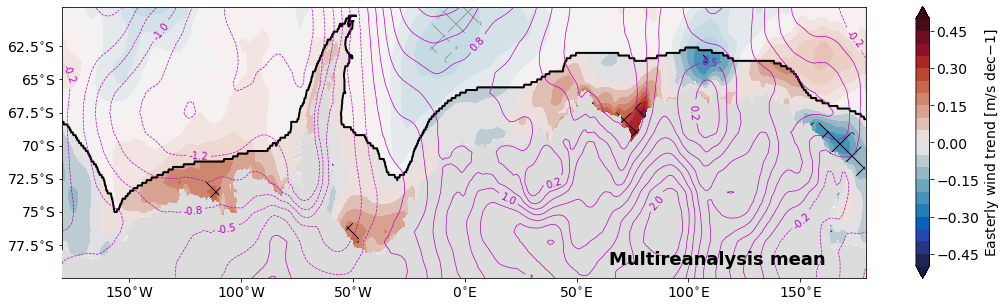

In [11]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 5))
ax = fig.add_subplot()
ax.text(0.95, .05, 'Multireanalysis mean', ha = 'right', transform = ax.transAxes, size = 18, weight = 'bold', zorder = 5)
ax.set_xlim([-180, 179.25])
ax.set_ylim([-80, -59.5])
ax.set_yticks(np.arange(-77.5, -60, 2.5))
ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', '70$^{\circ}$S', 
                    '67.5$^{\circ}$S', '65$^{\circ}$S', '62.5$^{\circ}$S'])
ax.set_xticks(np.arange(-150, 200, 50))
ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', 
                    '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
# Land
ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'gainsboro', 
            linewidths = 0.5, zorder = 3)
ax.pcolormesh(mask['lon'], mask['lat'], xr.where(np.isnan(mask), 1, np.nan), vmin = 1, 
              vmax = 1.1, cmap = 'binary', alpha = 0.6, zorder = 2)
ax.plot(div_line[0], div_line[1], 'k', linewidth = 2, zorder = 2)
k = 'reanalysis'
cf = ax.contourf(uas_trends[k]['lon'], uas_trends[k]['lat'], -uas_trends[k]['trend']*10, 
                     levels = np.arange(-.5, .55, .05), extend = 'both', cmap = cmocean.cm.balance)
ax.contourf(uas_trends[k]['lon'], uas_trends[k]['lat'], 
            uas_trends[k]['p'].where(uas_trends[k]['p'] <= .05),
            colors = ['none'], hatches = ['x'])
c = ax.contour(psl_historical_re[k]['lon'], psl_historical_re[k]['lat'], psl_historical_re[k]/100,
                   levels = np.arange(-3, 3.25, .25), colors = ['m'], linewidths = [0.7], zorder = 4)
ax.clabel(c, c.levels, inline=True, fmt='%1.1f', fontsize=10)

fig.colorbar(cf, ax = ax).set_label('Easterly wind trend [m/s dec${-1}$]')

plt.savefig('../results/v5/figsup3.jpg', bbox_inches = 'tight')

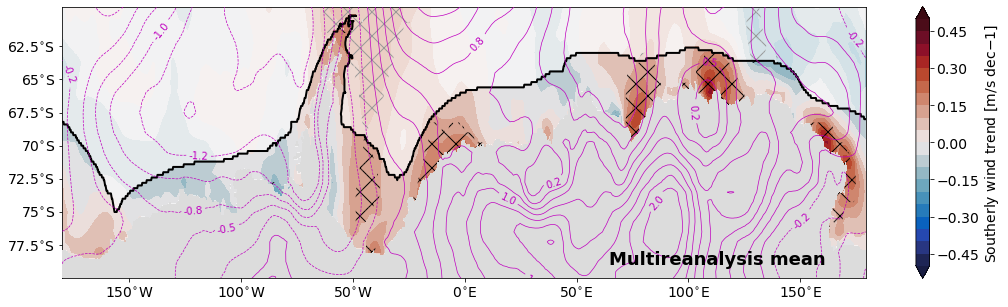

In [12]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 5))
ax = fig.add_subplot()
ax.text(0.95, .05, 'Multireanalysis mean', ha = 'right', transform = ax.transAxes, size = 18, weight = 'bold', zorder = 5)
ax.set_xlim([-180, 179.25])
ax.set_ylim([-80, -59.5])
ax.set_yticks(np.arange(-77.5, -60, 2.5))
ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', '70$^{\circ}$S', 
                    '67.5$^{\circ}$S', '65$^{\circ}$S', '62.5$^{\circ}$S'])
ax.set_xticks(np.arange(-150, 200, 50))
ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', 
                    '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
# Land
ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'gainsboro', 
            linewidths = 0.5, zorder = 3)
ax.pcolormesh(mask['lon'], mask['lat'], xr.where(np.isnan(mask), 1, np.nan), vmin = 1, 
              vmax = 1.1, cmap = 'binary', alpha = 0.6, zorder = 2)
ax.plot(div_line[0], div_line[1], 'k', linewidth = 2, zorder = 2)
k = 'reanalysis'
cf = ax.contourf(vas_trends[k]['lon'], vas_trends[k]['lat'], -vas_trends[k]['trend']*10, 
                     levels = np.arange(-.5, .55, .05), extend = 'both', cmap = cmocean.cm.balance)
ax.contourf(vas_trends[k]['lon'], vas_trends[k]['lat'], 
            vas_trends[k]['p'].where(vas_trends[k]['p'] <= .05),
            colors = ['none'], hatches = ['x'])
c = ax.contour(psl_historical_re[k]['lon'], psl_historical_re[k]['lat'], psl_historical_re[k]/100,
                   levels = np.arange(-3, 3.25, .25), colors = ['m'], linewidths = [0.7], zorder = 4)
ax.clabel(c, c.levels, inline=True, fmt='%1.1f', fontsize=10)

fig.colorbar(cf, ax = ax).set_label('Southerly wind trend [m/s dec${-1}$]')

plt.savefig('../results/v5/figsup4.jpg', bbox_inches = 'tight')

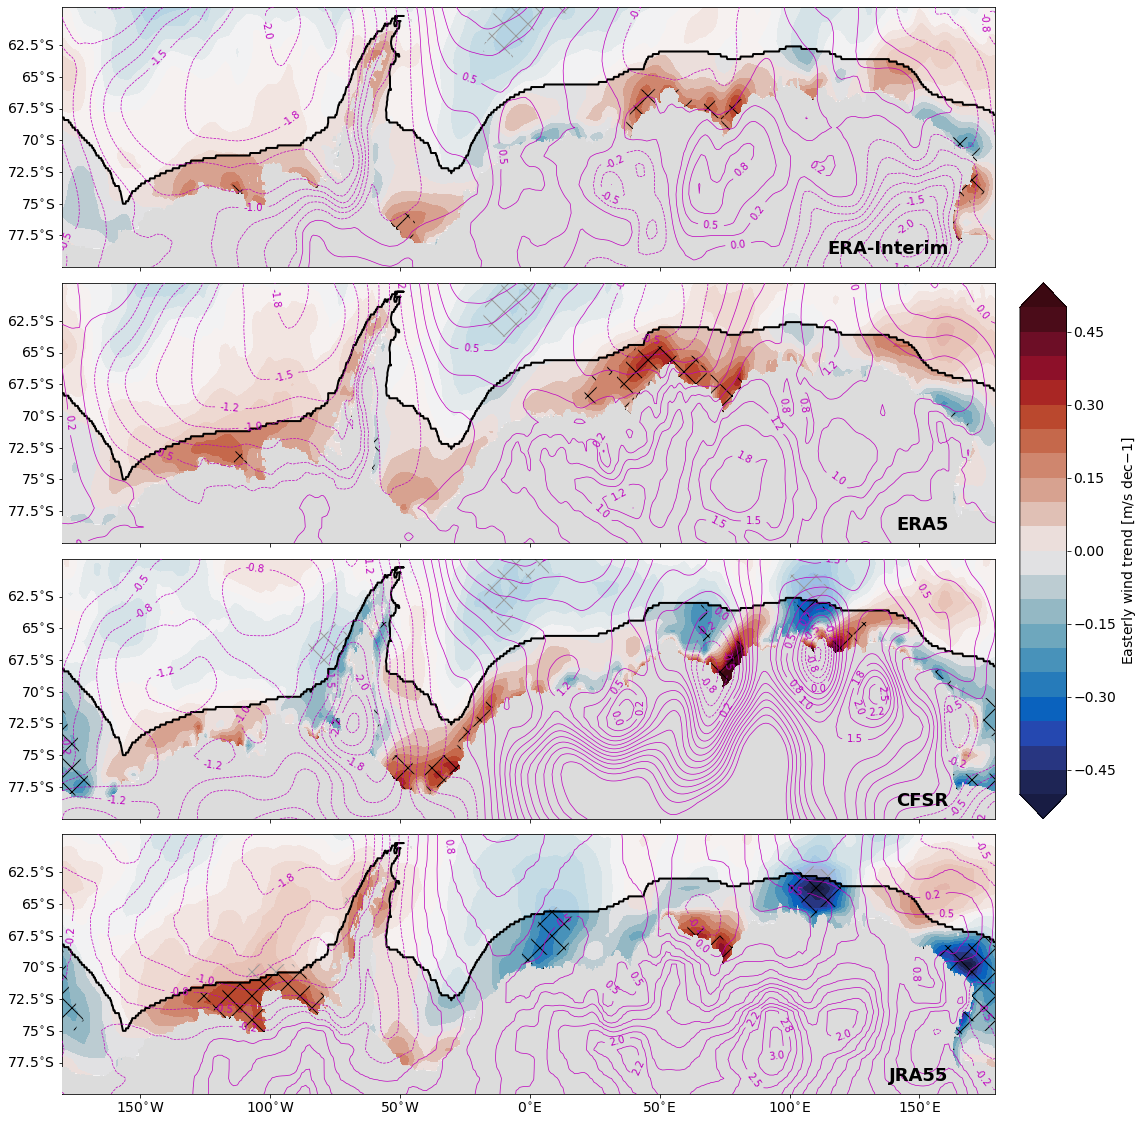

In [13]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 20))
gr = gs.GridSpec(4, 2, figure = fig, width_ratios = [1,.05], hspace = .06, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[2,0]),
       fig.add_subplot(gr[3,0]), 
       fig.add_subplot(gr[1:3,1])]
for ax, label in zip(axs[:-1], ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55']):
    ax.text(0.95, .05, label, ha = 'right', transform = ax.transAxes, size = 18, weight = 'bold', zorder = 5)
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-77.5, -60, 2.5))
    ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', '70$^{\circ}$S', 
                        '67.5$^{\circ}$S', '65$^{\circ}$S', '62.5$^{\circ}$S'])
    if ax in [axs[0], axs[1], axs[2]]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', 
                            '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'gainsboro', 
                linewidths = 0.5, zorder = 3)
    ax.pcolormesh(mask['lon'], mask['lat'], xr.where(np.isnan(mask), 1, np.nan), vmin = 1, 
                  vmax = 1.1, cmap = 'binary', alpha = 0.6, zorder = 2)
    ax.plot(div_line[0], div_line[1], 'k', linewidth = 2, zorder = 2)
    
n = 0
for k in keys[:-2]:
    cf = axs[n].contourf(uas_trends[k]['lon'], uas_trends[k]['lat'], -uas_trends[k]['trend']*10, 
                         levels = np.arange(-.5, .55, .05), extend = 'both', cmap = cmocean.cm.balance)
    axs[n].contourf(uas_trends[k]['lon'], uas_trends[k]['lat'], 
                    uas_trends[k]['p'].where(uas_trends[k]['p'] <= .05),
                    colors = ['none'], hatches = ['x'])
    c = axs[n].contour(psl_historical_re[k]['lon'], psl_historical_re[k]['lat'], psl_historical_re[k]/100,
                       levels = np.arange(-3, 3.25, .25), colors = ['m'], linewidths = [0.7], zorder = 4)
    axs[n].clabel(c, c.levels, inline=True, fmt='%1.1f', fontsize=10)
    n += 1
fig.colorbar(cf, cax = axs[-1]).set_label('Easterly wind trend [m/s dec${-1}$]')

plt.savefig('../results/v5/figsup5.jpg', bbox_inches = 'tight')

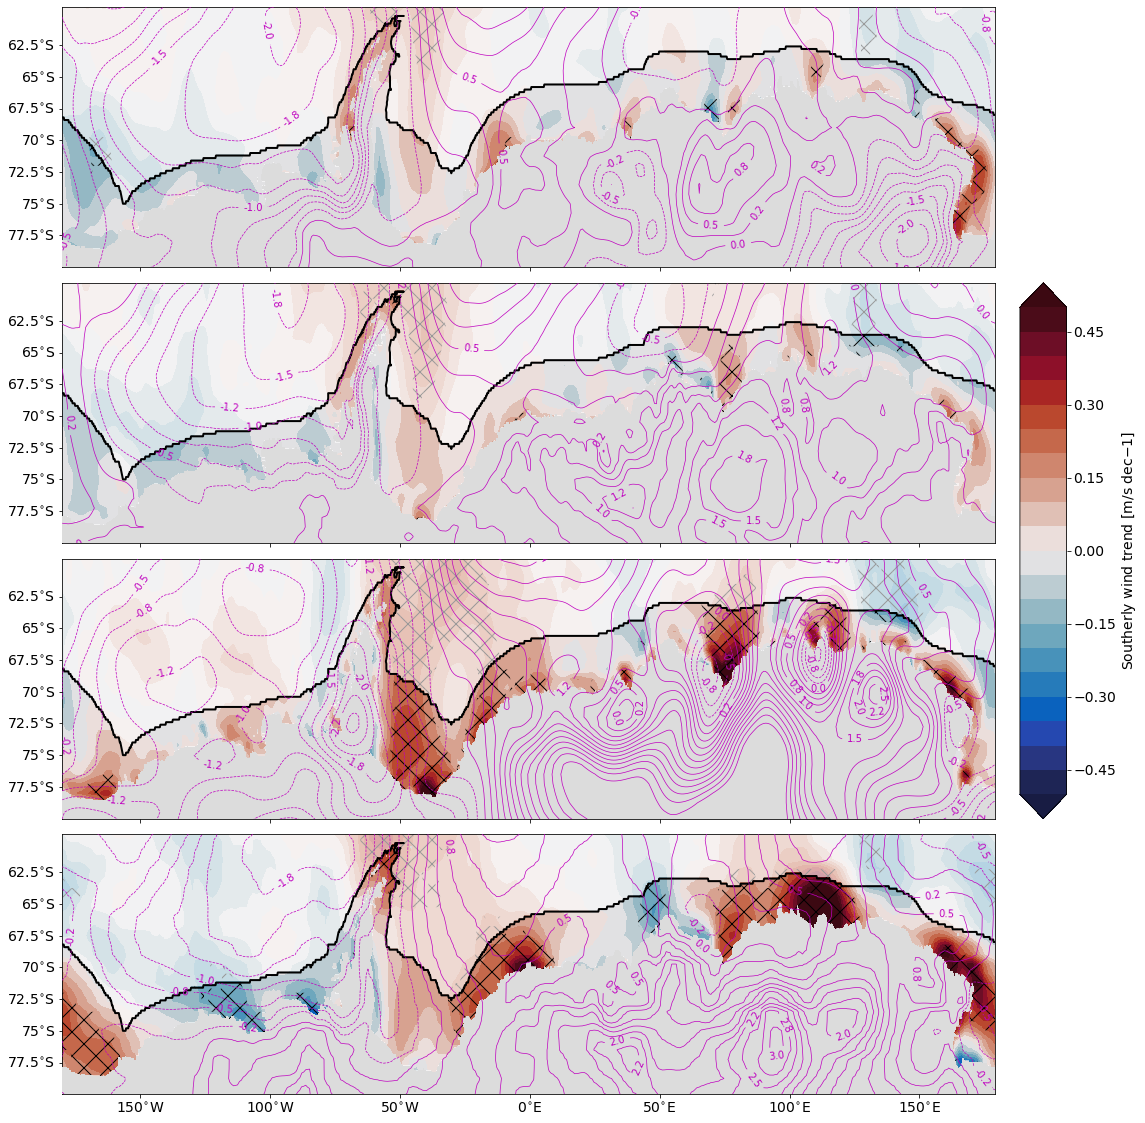

In [14]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 20))
gr = gs.GridSpec(4, 2, figure = fig, width_ratios = [1,.05], hspace = .06, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[2,0]),
       fig.add_subplot(gr[3,0]), 
       fig.add_subplot(gr[1:3,1])]
for ax, label in zip(axs[:-1], keys):
    ax.text(0.95, .05, label, ha = 'right', transform = ax.transAxes, size = 18, weight = 'bold')
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-77.5, -60, 2.5))
    ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', '70$^{\circ}$S', 
                        '67.5$^{\circ}$S', '65$^{\circ}$S', '62.5$^{\circ}$S'])
    if ax in [axs[0], axs[1], axs[2]]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', 
                            '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'gainsboro', 
                linewidths = 0.5, zorder = 3)
    ax.pcolormesh(mask['lon'], mask['lat'], xr.where(np.isnan(mask), 1, np.nan), vmin = 1, 
                  vmax = 1.1, cmap = 'binary', alpha = 0.6, zorder = 2)
    ax.plot(div_line[0], div_line[1], 'k', linewidth = 2, zorder = 2)
    
n = 0
for k in keys[:-2]:
    cf = axs[n].contourf(vas_trends[k]['lon'], vas_trends[k]['lat'], -vas_trends[k]['trend']*10, 
                         levels = np.arange(-.5, .55, .05), extend = 'both', cmap = cmocean.cm.balance)
    axs[n].contourf(vas_trends[k]['lon'], vas_trends[k]['lat'], 
                    vas_trends[k]['p'].where(vas_trends[k]['p'] <= .05),
                    colors = ['none'], hatches = ['x'])
    c = axs[n].contour(psl_historical_re[k]['lon'], psl_historical_re[k]['lat'], psl_historical_re[k]/100,
                       levels = np.arange(-3, 3.25, .25), colors = ['m'], linewidths = [0.7], zorder = 4)
    axs[n].clabel(c, c.levels, inline=True, fmt='%1.1f', fontsize=10)
    n += 1
fig.colorbar(cf, cax = axs[-1]).set_label('Southerly wind trend [m/s dec${-1}$]')

plt.savefig('../results/v4/figsup6.jpg', bbox_inches = 'tight')